## Hands-on tutorials - Fourier Neural Operator for 1D Burgers equation

- Author: Xiaoyu Xie
- Email: xiaoyuxie2020@u.northwestern.edu
- Date: May 25, 2024


In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything
from scipy.io import loadmat
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

## System configuration

In [2]:
# set random seed for reproducibility
seed_everything(seed=0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# choose a specific GPU ID
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')

# print pytorch version and cuda version
print(torch.__version__)

Global seed set to 0


1.13.0+cu116


### Define FNO model

In [3]:
class SpectralConv1d(nn.Module):
    """
    Spectral Convolutional 1D Layer.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        modes1 (int): Number of Fourier modes to multiply, at most floor(N/2) + 1.

    Attributes:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        modes1 (int): Number of Fourier modes to multiply, at most floor(N/2) + 1.
        scale (float): Scaling factor for the weights.
        weights1 (nn.Parameter): Learnable weights for the convolution.

    Methods:
        compl_mul1d(input, weights): Performs complex multiplication between input and weights.
        forward(x): Forward pass of the SpectralConv1d layer.
    """

    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes are kept, at most floor(N/2) + 1

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        """
        Performs complex multiplication between input and weights.

        Args:
            input (torch.Tensor): Input tensor of shape (batch, in_channel, x).
            weights (torch.Tensor): Weights tensor of shape (in_channel, out_channel, x).

        Returns:
            torch.Tensor: Result of complex multiplication of input and weights, of shape (batch, out_channel, x).
        """
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        # in_channel is the common dimension along which the operation is performed. 
        # It suggests that every channel (or feature) of the input is being transformed into a new set of channels (or features) in the output.
        # The operation iterates over each batch and each position x, multiplying the input channels 
        # by the corresponding weights and summing the results to produce the output channels.
        
        # For a given position i in the x dimension and a given batch element:
        # Take all values in A at this position and batch (A[batch, :, i]) – a slice of shape (in_channel).
        # Take all corresponding values in B at this position (B[:, :, i]) – a matrix of shape (in_channel, out_channel).
        # Multiply these values element-wise and sum over the in_channel dimension.
        # This produces a vector of shape (out_channel), representing the transformed features at position i for this batch element.
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        # Compute Fourier coeffcients
        x_ft = torch.fft.rfft(x)  # [Batch, C_in, Nx] -> [Batch, C_in, Nx//2 + 1], eg. [20, 64, 128] -> [20, 64, 65]
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(x.shape[0], self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat) # [Batch, Nc, Nx//2 + 1], eg. [20, 64, 65]
        # [Batch, C_in, self.modes1] * [C_in, C_out, self.modes1] -> [Batch, C_out, self.modes1]
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)  

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))  # [Batch, C_out, self.modes1] -> [Batch, C_out, Nx], eg. [20, 64, 65] -> [20, 64, 128]
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        """
        1D Fourier Neural Operator model.

        Args:
            modes (int): Number of spectral modes.
            width (int): Number of hidden channel.
        """
        super(FNO1d, self).__init__()
        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x) MeshgridTensor + initial condition

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # stage 1: lift the channel from 2 to self.width = 64
        x = self.fc0(x)         # [Batch, Nx, C] -> [Batch, Nx, Width], eg. [20, 128, 2] -> [20, 128, 64]
        x = x.permute(0, 2, 1)  # [Batch, C, Nx], eg. [20, 64, 128]

        # stage 2: integral operators u' = (W + K)(u).
        # W is the linear transformation; K is the spectral convolution kernel.
        x1 = self.conv0(x)      # [Batch, C, Nx], eg. [20, 64, 128]
        x2 = self.w0(x)         # [Batch, C, Nx], eg. [20, 64, 128]
        x = x1 + x2
        x = F.relu(x)           # [Batch, C, Nx], eg. [20, 64, 128]

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.relu(x)           # [Batch, C, Nx], eg. [20, 64, 128]

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.relu(x)           # [Batch, C, Nx], eg. [20, 64, 128]

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2             # [Batch, C, Nx], eg. [20, 64, 128]

        # stage 3: put the channel back to 1
        x = x.permute(0, 2, 1)  # [Batch, Nx, C], eg. [20, 128, 64]
        x = self.fc1(x)         # [Batch, Nx, C] -> [Batch, Nx, 128], eg. [20, 128, 64] -> [20, 128, 128]
        x = F.relu(x)
        x = self.fc2(x)         # [Batch, Nx, C] -> [Batch, Nx, 1], eg. [20, 128, 128] -> [20, 128, 1]
        
        # since there are only one output
        x = x.squeeze(-1)       # [Batch, Nx, 1] -> [Batch, Nx], eg. [20, 128, 1] -> [20, 128]
        
        return x


### Configuration

In [4]:
class Config():
    #========================#
    # Training parameters
    #========================#
    num_epoch = 500                  # number of training epoch
    # num_epoch = 20                 # for debugging
    batch_size = 20                  # batch size
    
    # Adam optimizer parameters
    weight_decay = 1e-4              # weight decay for Adam optimizer
    
    # learning rate decay parameters
    lr = 0.001                       # learning rate
    step_size = 100                  # step size for step-wise learning rate decay
    gamma = 0.5                      # the decay coefficient for step-wise learning rate decay
    
    modes = 16                       # number of Fourier modes to multiply, at most floor(N/2) + 1
    width = 64                       # number of hidden channel
    
    #========================#
    # dataset information
    #========================#
    # download dataset from: https://drive.google.com/file/d/16a8od4vidbiNR3WtaBPCSZ0T3moxjhYe/view?usp=drive_link
    dataset_path = 'dataset/burgers_data_R10.mat'      
    sub = 8                             # downsample rate for spatial dimension
    resolution_original = 2**13         # original resolution of the dataset
    num_train = 1000                    # number of training data
    num_test = 200                      # number of test data
    
    #========================#
    # results
    #========================#
    model_path = 'results/model_burgers_R10'
    checkpoint_dir = 'results/checkpoints_burgers_R10'
    
cfg = Config()

### Dataset preparation

In [5]:
def prepare_data(raw_data, sub, cfg):
    """
    Load raw data and prepare data loaders.
    """
    x_data = torch.Tensor(raw_data['a'])[:, ::sub]  # (num_trajectory, Nx): (2048, 1024) 
    y_data = torch.Tensor(raw_data['u'])[:, ::sub]  # (num_trajectory, Nx): (2048, 1024) 
    print(f'[Dataset] downsampled raw data - x_data: {x_data.shape}, y_data: {y_data.shape}')
    
    # Split into train and test
    x_train, y_train = x_data[:cfg.num_train, :], y_data[:cfg.num_train, :]
    x_test, y_test = x_data[-cfg.num_test:, :], y_data[-cfg.num_test:, :]
    print(f'[Dataset] x_train: {x_train.shape}, y_train: {y_train.shape}')
    print(f'[Dataset] x_test: {x_test.shape}, y_test: {y_test.shape}')

    # Prepare grid information (optional)
    grid_all = np.linspace(0, 1, cfg.resolution_original).reshape(cfg.resolution_original, 1).astype(np.float64)
    grid = grid_all[::sub, :]
    grid = torch.tensor(grid, dtype=torch.float) 

    # Concatenate the spatial grid and the spatial solution
    x_train = torch.cat([x_train.reshape(cfg.num_train, -1, 1), grid.repeat(cfg.num_train, 1, 1)], dim=2)
    x_test = torch.cat([x_test.reshape(cfg.num_test, -1, 1), grid.repeat(cfg.num_test, 1, 1)], dim=2)

    # Create data loaders
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=cfg.batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=cfg.batch_size, shuffle=False)
    
    return train_loader, test_loader

class DataModule(pl.LightningDataModule):
    """
    Data module for loading data in PyTorch Lightning.
    """
    def __init__(self, dataset_path, sub, cfg):
        super(DataModule, self).__init__()
        self.dataset_path = dataset_path
        self.sub = sub
        self.cfg = cfg
        self.train_loader = None
        self.test_loader = None

    def setup(self, stage=None):
        # Load training data
        raw_data = loadmat(self.dataset_path)  # Load data as a dictionary
        self.train_loader, self.test_loader = prepare_data(raw_data, self.sub, self.cfg)
        print('[DataModule] Data loaders have been set up.')

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.test_loader

    def test_dataloader(self):
        return self.test_loader

data_module = DataModule(cfg.dataset_path, cfg.sub, cfg)
data_module.setup()

[Dataset] downsampled raw data - x_data: torch.Size([2048, 1024]), y_data: torch.Size([2048, 1024])
[Dataset] x_train: torch.Size([1000, 1024]), y_train: torch.Size([1000, 1024])
[Dataset] x_test: torch.Size([200, 1024]), y_test: torch.Size([200, 1024])
[DataModule] Data loaders have been set up.


## Model training & evaluation

In [6]:
class PlModel(pl.LightningModule):
    """
    PyTorch Lightning module for training the FNO model.
    """
    def __init__(self, cfg):
        super(PlModel, self).__init__()
        self.model = FNO1d(cfg.modes, cfg.width)
        self.cfg = cfg
        self.metrics = {'train_loss': [], 'val_loss': [], 'test_loss': []}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat.view(-1, 1), y.view(-1, 1))
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.metrics['train_loss'].append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat.view(-1, 1), y.view(-1, 1))
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.metrics['val_loss'].append(loss.item())
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat.view(-1, 1), y.view(-1, 1))
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.metrics['test_loss'].append(loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=self.cfg.step_size, gamma=self.cfg.gamma)
        return [optimizer], [scheduler]

    def evaluate_at_different_resolutions(self, raw_data, resolution_test_list):
        for resolution_test in resolution_test_list:
            print('[Test] resolution_test: ', resolution_test)
            sub = self.cfg.resolution_original // resolution_test
            _, test_loader = prepare_data(raw_data, sub, self.cfg)

            self.eval()
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(self.device), y.to(self.device)
                    pred = self(x)

                    # Plot comparison for the first example in the batch
                    plt.figure()
                    plt.plot(pred[0].cpu().numpy(), 'r', label='Prediction')
                    plt.plot(y[0].cpu().numpy(), 'b', label='Ground Truth')
                    plt.scatter(np.arange(resolution_test), pred[0].cpu().numpy(), c='r')
                    plt.scatter(np.arange(resolution_test), y[0].cpu().numpy(), c='b')
                    plt.legend(loc='upper right')
                    plt.title(f'resolution_test: {resolution_test}')
                    plt.show()
                
                    # only plot the first batch
                    break


/home/xxd5545/.conda/envs/torch2/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/xxd5545/.conda/envs/torch2/lib/python3.9/site- ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


[Dataset] downsampled raw data - x_data: torch.Size([2048, 1024]), y_data: torch.Size([2048, 1024])
[Dataset] x_train: torch.Size([1000, 1024]), y_train: torch.Size([1000, 1024])
[Dataset] x_test: torch.Size([200, 1024]), y_test: torch.Size([200, 1024])
[DataModule] Data loaders have been set up.


/home/xxd5545/.conda/envs/torch2/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /mnt/a/xxd5545/Sci-ML-Book/FNO/FNO-1D/results/checkpoints_burgers_R10 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type  | Params
--------------------------------
0 | model | FNO1d | 287 K 
--------------------------------
287 K     Trainable params
0         Non-trainable params
287 K     Total params
1.150     Total estimated model params size (MB)
/home/xxd5545/.conda/envs/torch2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performan

[Dataset] downsampled raw data - x_data: torch.Size([2048, 1024]), y_data: torch.Size([2048, 1024])
[Dataset] x_train: torch.Size([1000, 1024]), y_train: torch.Size([1000, 1024])
[Dataset] x_test: torch.Size([200, 1024]), y_test: torch.Size([200, 1024])
[DataModule] Data loaders have been set up.
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          6.715315976180136e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/xxd5545/.conda/envs/torch2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[Test] resolution_test:  64
[Dataset] downsampled raw data - x_data: torch.Size([2048, 64]), y_data: torch.Size([2048, 64])
[Dataset] x_train: torch.Size([1000, 64]), y_train: torch.Size([1000, 64])
[Dataset] x_test: torch.Size([200, 64]), y_test: torch.Size([200, 64])


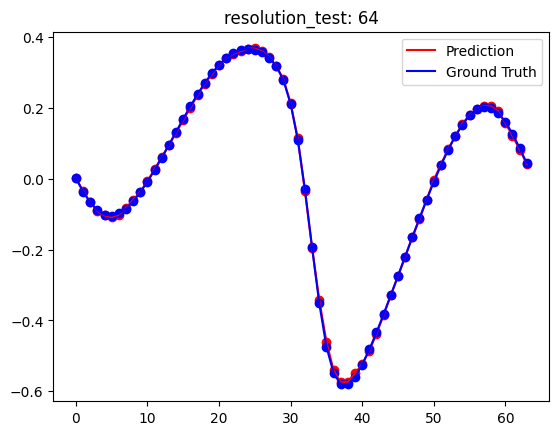

[Test] resolution_test:  256
[Dataset] downsampled raw data - x_data: torch.Size([2048, 256]), y_data: torch.Size([2048, 256])
[Dataset] x_train: torch.Size([1000, 256]), y_train: torch.Size([1000, 256])
[Dataset] x_test: torch.Size([200, 256]), y_test: torch.Size([200, 256])


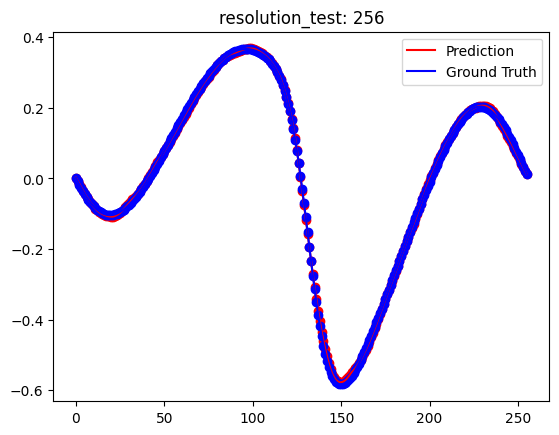

[Test] resolution_test:  1024
[Dataset] downsampled raw data - x_data: torch.Size([2048, 1024]), y_data: torch.Size([2048, 1024])
[Dataset] x_train: torch.Size([1000, 1024]), y_train: torch.Size([1000, 1024])
[Dataset] x_test: torch.Size([200, 1024]), y_test: torch.Size([200, 1024])


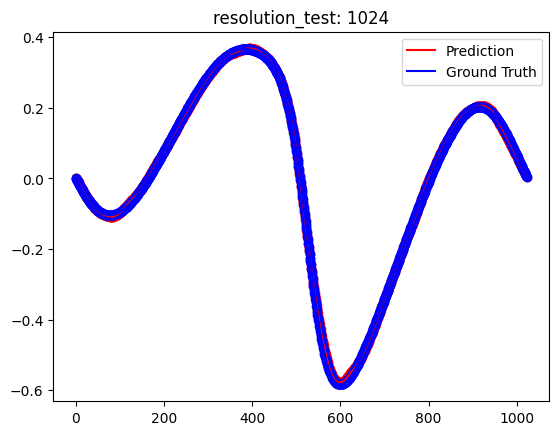

In [7]:
# train the model
model = PlModel(cfg)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=cfg.checkpoint_dir,
    filename='fno-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)
trainer = pl.Trainer(
    max_epochs=cfg.num_epoch,
    callbacks=[checkpoint_callback],
    accelerator='gpu', 
    devices=1,
    enable_progress_bar=False, # disable progress bar for jupyter notebook, it's better to enable it for python script
)
# train the model
trainer.fit(model, data_module)
# test the model
trainer.test(model, data_module.test_dataloader())

# Evaluate the model at different resolutions
raw_data = loadmat(cfg.dataset_path)  # Ensure this is loaded correctly
resolution_test_list = [64, 256, 1024]
model.evaluate_at_different_resolutions(raw_data, resolution_test_list)

### plot training and validation loss

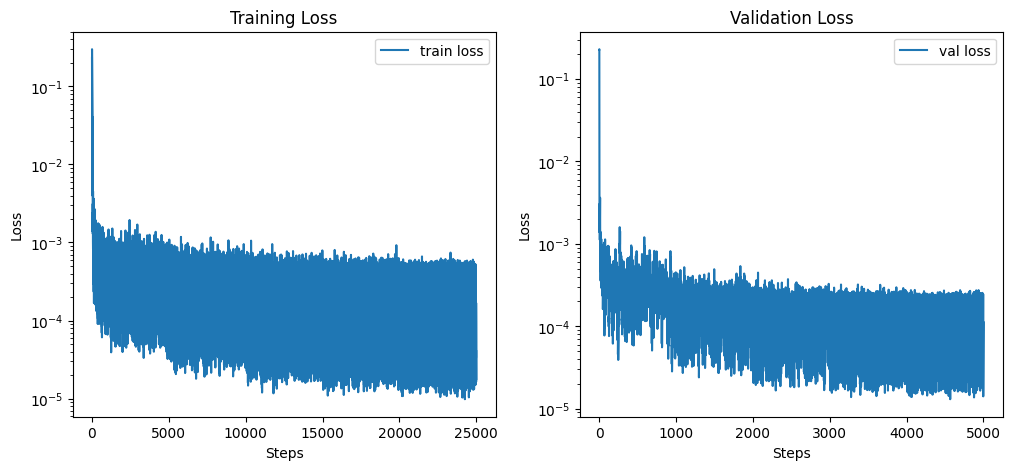

In [8]:
# plot the training loss and validation loss in two subplots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(model.metrics['train_loss'], label='train loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.metrics['val_loss'], label='val loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Validation Loss')
plt.legend()
plt.show()

# Reference

- FNO paper: Li, Z., Kovachki, N., Azizzadenesheli, K., Liu, B., Bhattacharya, K., Stuart, A., & Anandkumar, A. (2020). Fourier neural operator for parametric partial differential equations. arXiv preprint arXiv:2010.08895
- FNO official github: https://github.com/neuraloperator/neuraloperator/?tab=readme-ov-file
- FNO tutorial: https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_FNO_in_JAX.ipynb
- DeepONet & FNO: https://github.com/lu-group/deeponet-fno
- FNO documentation: https://neuraloperator.github.io/neuraloperator/dev/user_guide/neural_operators.html
- FNO blog: https://zongyi-li.github.io/blog/2020/fourier-pde/
- FNO news: https://www.technologyreview.com/2020/10/30/1011435/ai-fourier-neural-network-cracks-navier-stokes-and-partial-differential-equations/
- Wikipedia: https://en.wikipedia.org/wiki/Neural_operators
- Julia: https://docs.sciml.ai/NeuralOperators/stable/introduction/

## Citation
If you find this tutorial helpful, please cite it:
```
@book{xie2024sml,
  title={Hands-on Scientific Machine Learning},
  author={Xiaoyu Xie},
  url={https://xiaoyuxie.top/Sci-ML-Book},
  year={2024},
  publisher={WWW}
}
```